# Comparing regression models

Here we will analyze different regression models and ensembles to solve the stated problem: make a forecast of houses prices

In [22]:
# main imports

from datetime import datetime, timedelta

import numpy as np
print('Numpy version: ', np.__version__)
import pandas as pd
print('Pandas version: ', pd.__version__)
import matplotlib as mpl
from matplotlib import pyplot as plt
print('Matplotlib version: ', mpl.__version__)
import seaborn as sns
print('Seaborn version: ', sns.__version__)

import sklearn as skl
print('Scikit-learn version: ', skl.__version__)
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import xgboost as xgb
import catboost as ctb
import lightgbm as lgbm

import joblib

from tqdm import tqdm

Numpy version:  1.23.5
Pandas version:  1.5.2
Matplotlib version:  3.6.2
Seaborn version:  0.12.1
Scikit-learn version:  1.1.3


Performance measure is **Root-Mean-Squared-Error (RMSE) between the logarithm** of the predicted value and the logarithm of the observed sales price.  
Taking logs means that errors in predicting expensive houses and cheap houses will affect the result almost equally

In [2]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer

In [4]:
%matplotlib widget

## Loading data

In [3]:
y = pd.read_csv('datasets/train.csv', index_col=0)['SalePrice']
y.head()

Id
1    208500
2    181500
3    223500
4    140000
5    250000
Name: SalePrice, dtype: int64

In [4]:
y_target = np.log(y)
y_target.head()

Id
1    12.247694
2    12.109011
3    12.317167
4    11.849398
5    12.429216
Name: SalePrice, dtype: float64

Getting prepared X data

In [5]:
# importing from human readable dataframe format
X = pd.read_csv('datasets/processed/train_sel_feat_boruta.csv', index_col=0)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        1460 non-null   float64
 1   LotArea            1460 non-null   float64
 2   OverallQual        1460 non-null   float64
 3   OverallCond        1460 non-null   float64
 4   YearBuilt          1460 non-null   float64
 5   YearRemodAdd       1460 non-null   float64
 6   BsmtQual           1460 non-null   float64
 7   BsmtFinType1       1460 non-null   float64
 8   BsmtFinSF1         1460 non-null   float64
 9   TotalBsmtSF        1460 non-null   float64
 10  1stFlrSF           1460 non-null   float64
 11  2ndFlrSF           1460 non-null   float64
 12  GrLivArea          1460 non-null   float64
 13  FullBath           1460 non-null   float64
 14  KitchenAbvGr       1460 non-null   float64
 15  KitchenQual        1460 non-null   float64
 16  FireplaceQu        1460 

In [6]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtQual,BsmtFinType1,BsmtFinSF1,TotalBsmtSF,...,AgeBuilt,AgeRemodeled,AgeGarage,MSSubClass_30,MSZoning_C (all),MSZoning_RM,CentralAir_N,CentralAir_Y,GarageType_Attchd,GarageType_Detchd
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,7.0,5.0,2003.0,2003.0,4.0,6.0,706.0,856.0,...,19.0,19.0,19.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,80.0,9600.0,6.0,8.0,1976.0,1976.0,4.0,5.0,978.0,1262.0,...,46.0,46.0,46.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,68.0,11250.0,7.0,5.0,2001.0,2002.0,4.0,6.0,486.0,920.0,...,21.0,20.0,21.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,60.0,9550.0,7.0,5.0,1915.0,1970.0,3.0,5.0,216.0,756.0,...,107.0,52.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,84.0,14260.0,8.0,5.0,2000.0,2000.0,4.0,6.0,655.0,1145.0,...,22.0,22.0,22.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y_target, test_size=0.2, random_state=42)
print('Train set size: ', X_train.shape, y_train.shape)
print('Validation set size: ', X_val.shape, y_val.shape)

Train set size:  (1168, 31) (1168,)
Validation set size:  (292, 31) (292,)


In [7]:
# If loaded dataset created with Boruta then not needed to scale
scaler_mm = MinMaxScaler()
X_train_scaled = scaler_mm.fit_transform(X_train)
X_val_scaled = scaler_mm.transform(X_val)

In [8]:
models_results = {
    'model_name': [],
    'model': [],
    'baseline_mean_train': [],
    'baseline_std_train': [],
    'baseline_mean_val': [],
    'baseline_std_val': [],
    'opt_mean_train': [],
    'opt_std_train': [],
    'opt_mean_val': [],
    'opt_std_val': [],
    'param_search_res': [],
    'learn_curve_train': [],
    'learn_curve_val': [],
    'x_scaled': []
}

## Some useful functions

In [9]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean: {:.4f}".format(scores.mean()))
    print("Standard deviation: {:.4f}".format(scores.std()))

In [35]:
def get_learning_curve_data(model, X_train, y_train, X_val=None, y_val=None, step=3):
    if type(X_train) == pd.DataFrame:
        X_np = X_train.to_numpy()
    else:
        X_np = X_train

    if X_val is not None:
        X_t = X_np
        y_t = y_train
        y_v = y_val
        if type(X_val) == pd.DataFrame:
            X_v = X_val.to_numpy()
        else:
            X_v = X_val
    else:
        X_t, X_v, y_t, y_v = train_test_split(X_np, y_train, test_size=0.2)
    
    train_errors, val_errors = [], []
    for m in range(2, len(X_t), step):
        model.fit(X_t[:m], y_t[:m])
        y_t_predict = model.predict(X_t[:m])
        y_v_predict = model.predict(X_v)
        train_errors.append(mean_squared_error(y_t[:m], y_t_predict))
        val_errors.append(mean_squared_error(y_v, y_v_predict))

    return (train_errors, val_errors)
    #fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    #plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    #plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

In [38]:
def plot_learning_curve(model_name, lc_train_error=None, lc_val_error=None):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    if lc_train_error is not None:
        plt.plot(np.sqrt(lc_train_error), "r-+", linewidth=2, label="train")
    if lc_val_error is not None:
        plt.plot(np.sqrt(lc_val_error), "b-", linewidth=3, label="val")
    plt.legend()
    plt.title(f'Learning curve of the {model_name} model')
    #ax.set_ybound(lower=0.0, upper=1e5)
    ax.set_ylabel('Mean squared error (MSE) from logged prices')
    upper_x_bound = (int(len(lc_train_error)/100)+1)*100
    ax.set_xbound(lower=0, upper=upper_x_bound)
    ax.set_xlabel('Num of instances')
    ax.set_xticks(range(0, upper_x_bound+1, 100))
    ax.set_xticklabels([str(3*x) for x in range(0, upper_x_bound+1, 100)]);

## Some words about testing models

This file is intended to be an initial playground to experiment and compare different models' (neural nets excluded) results and performance.  
Testing sequence:  
- creating model of each class with default configuration
- fitting on a train set and getting initial (baseline) metric value and time-to-fit on train and validation sets
- if available - perform GridSearchCV or/and RandomizedSearchCV to receive a configuration with better performance
- try to get data to plot learning curves for model
- log results  
  
Finally compare results on saved metrics.  


## XGBoost Regression

In [11]:
model_name = 'XGBoostRegression'
model = xgb.XGBRegressor(learning_rate=0.01, max_depth=5, subsample=1.0) # subsample=0.5
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
# getting baseline scores
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train, y_train, X_val, y_val)
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: baseline regression train score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_train)), np.sqrt(np.std(cv_res_train))))
print('{}: baseline regression val score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_val)), np.sqrt(np.std(cv_res_val))))

[0]	validation_0-rmse:11.39063
[1]	validation_0-rmse:11.27666
[2]	validation_0-rmse:11.16383
[3]	validation_0-rmse:11.05212
[4]	validation_0-rmse:10.94154
[5]	validation_0-rmse:10.83205
[6]	validation_0-rmse:10.72367
[7]	validation_0-rmse:10.61637
[8]	validation_0-rmse:10.51014
[9]	validation_0-rmse:10.40498
[10]	validation_0-rmse:10.30087
[11]	validation_0-rmse:10.19780
[12]	validation_0-rmse:10.09577
[13]	validation_0-rmse:9.99475
[14]	validation_0-rmse:9.89475
[15]	validation_0-rmse:9.79575
[16]	validation_0-rmse:9.69773
[17]	validation_0-rmse:9.60070
[18]	validation_0-rmse:9.50464
[19]	validation_0-rmse:9.40955
[20]	validation_0-rmse:9.31540
[21]	validation_0-rmse:9.22220
[22]	validation_0-rmse:9.12993
[23]	validation_0-rmse:9.03858
[24]	validation_0-rmse:8.94815
[25]	validation_0-rmse:8.85863
[26]	validation_0-rmse:8.77000
[27]	validation_0-rmse:8.68233
[28]	validation_0-rmse:8.59553
[29]	validation_0-rmse:8.50960
[30]	validation_0-rmse:8.42453
[31]	validation_0-rmse:8.34031
[32]	

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\2669310395.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model.fit(X_t[:m], y_t[:m])
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\2669310395.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_errors.append(mean_squared_error(y_t[:m], y_t_predict))
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\2669310395.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a fu

XGBoostRegression: baseline regression train score = 4.24 +/- 0.43
XGBoostRegression: baseline regression val score = 4.25 +/- 0.65


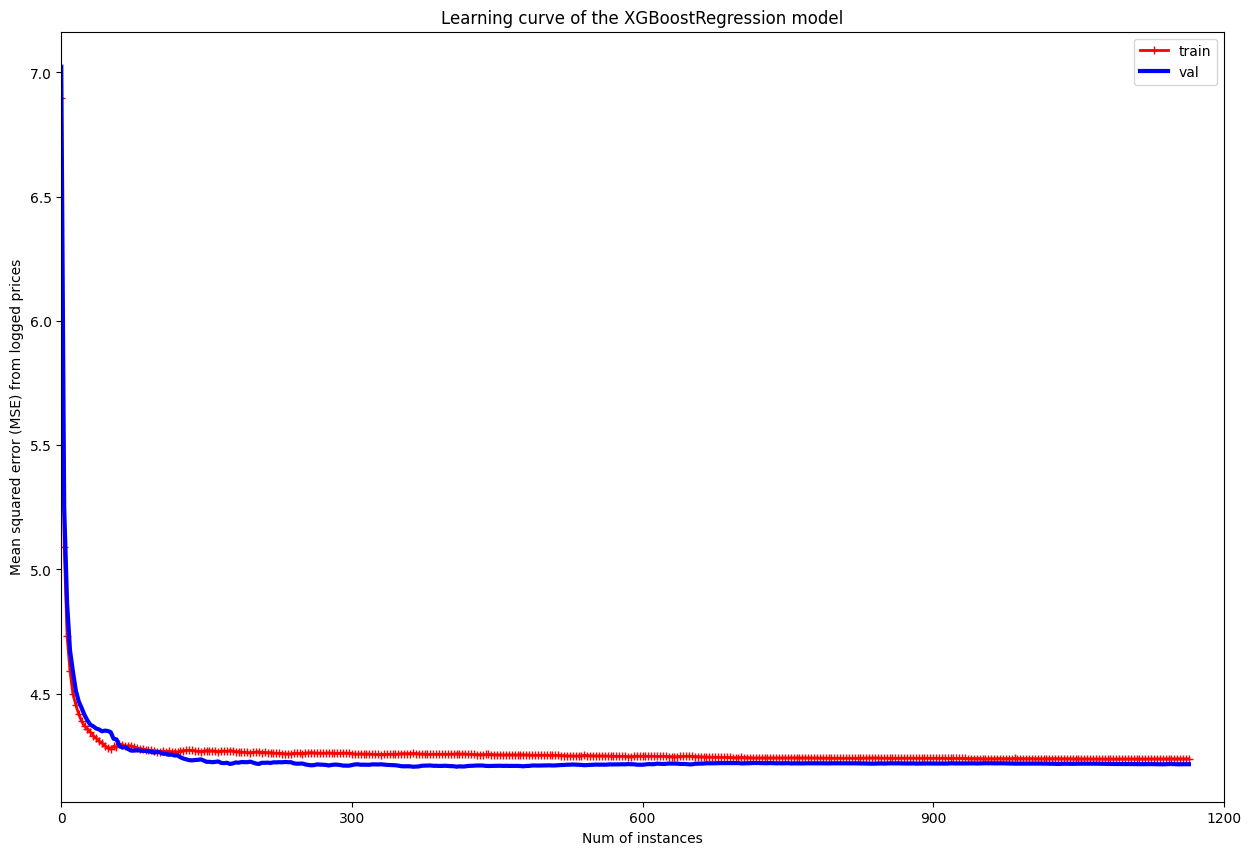

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(lc_train_error), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(lc_val_error), "b-", linewidth=3, label="val")
plt.legend()
plt.title(f'Learning curve of the {model_name} model')
#ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE) from logged prices')
upper_x_bound = (int(len(lc_train_error)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
ax.set_xticks(range(0, upper_x_bound+1, 100))
ax.set_xticklabels([str(3*x) for x in range(0, upper_x_bound+1, 100)]);

In [14]:
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.01, max_bin...
                                    max_delta_step=0, max_depth=5, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0, ...),
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [15]:
# performing after hyperparams optimization using GridSearchCV or RandomizedSearchCV
model = gscv.best_estimator_
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train, y_train, X_val, y_val)
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: optimized linear regression train score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_train)), np.sqrt(np.std(cv_res_train))))
print('{}: optimized linear regression val score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_val)), np.sqrt(np.std(cv_res_val))))

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\2669310395.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model.fit(X_t[:m], y_t[:m])
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\2669310395.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_errors.append(mean_squared_error(y_t[:m], y_t_predict))
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\2669310395.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a fu

XGBoostRegression: optimized linear regression train score = 0.13 +/- 0.06
XGBoostRegression: optimized linear regression val score = 0.16 +/- 0.11


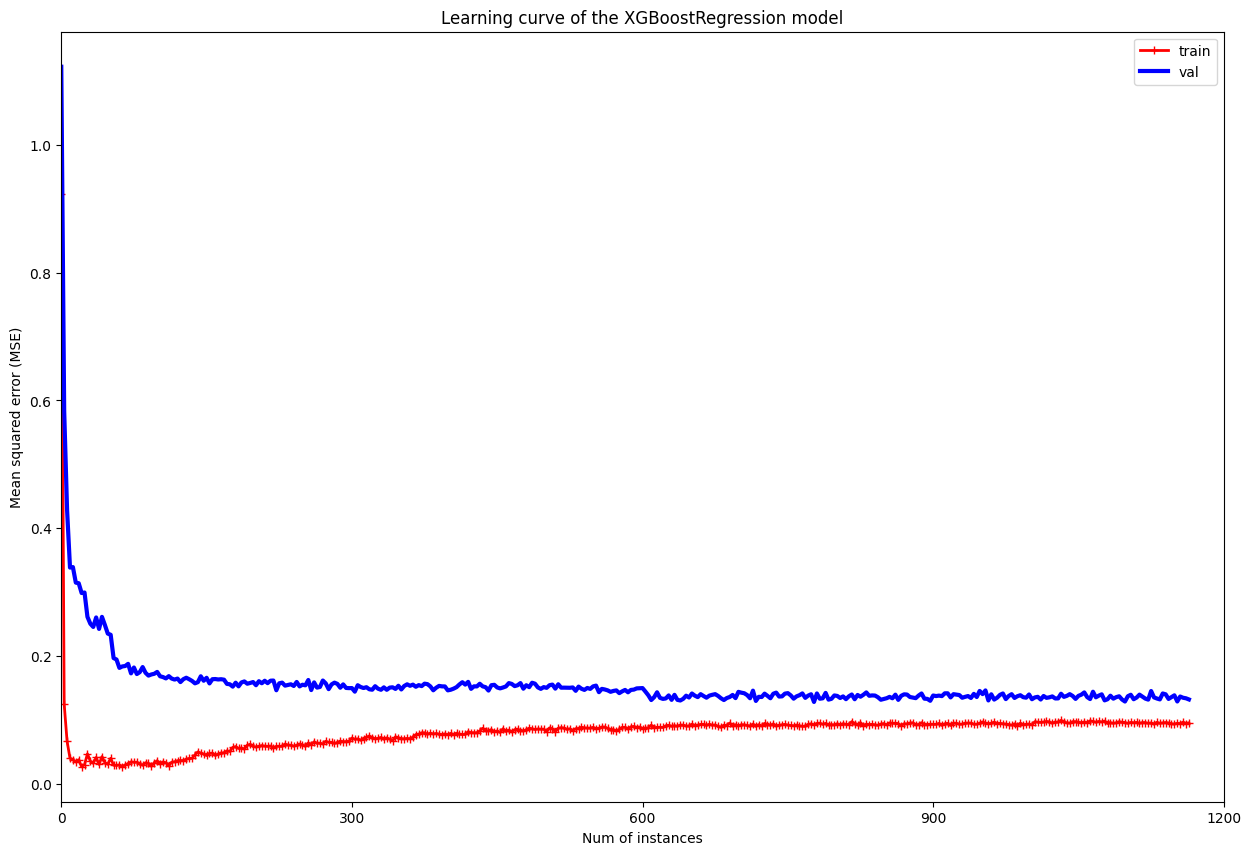

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(lc_train_error), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(lc_val_error), "b-", linewidth=3, label="val")
plt.legend()
plt.title(f'Learning curve of the {model_name} model')
#ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(lc_train_error)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
ax.set_xticks(range(0, upper_x_bound+1, 100))
ax.set_xticklabels([str(3*x) for x in range(0, upper_x_bound+1, 100)]);

In [23]:
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: optimized regression train score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_train)), np.sqrt(np.std(cv_res_train))))
print('{}: optimized regression val score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_val)), np.sqrt(np.std(cv_res_val))))

XGBoostRegression: optimized regression train score = 30487.90 +/- 15605.76
XGBoostRegression: optimized regression val score = 33727.50 +/- 22291.02


Making prediction to submit at Kaggle

In [18]:
df_test = pd.read_csv('datasets/processed/test_sel_feat_boruta.csv', index_col=0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        1459 non-null   float64
 1   LotArea            1459 non-null   float64
 2   OverallQual        1459 non-null   float64
 3   OverallCond        1459 non-null   float64
 4   YearBuilt          1459 non-null   float64
 5   YearRemodAdd       1459 non-null   float64
 6   BsmtQual           1459 non-null   float64
 7   BsmtFinType1       1459 non-null   float64
 8   BsmtFinSF1         1459 non-null   float64
 9   TotalBsmtSF        1459 non-null   float64
 10  1stFlrSF           1459 non-null   float64
 11  2ndFlrSF           1459 non-null   float64
 12  GrLivArea          1459 non-null   float64
 13  FullBath           1459 non-null   float64
 14  KitchenAbvGr       1459 non-null   float64
 15  KitchenQual        1459 non-null   float64
 16  FireplaceQu        14

In [19]:
predictions = np.exp(model.predict(df_test))
df_predictions = pd.Series(predictions, index=df_test.index, name='SalePrice')
df_predictions.info()

<class 'pandas.core.series.Series'>
Int64Index: 1459 entries, 1461 to 2919
Series name: SalePrice
Non-Null Count  Dtype  
--------------  -----  
1459 non-null   float32
dtypes: float32(1)
memory usage: 17.1 KB


In [20]:
df_predictions.to_csv('datasets/test_predictions_v3.csv')

### LightGBM

In [36]:
model_name = 'LightGBMRegression'
model = lgbm.LGBMRegressor(boosting_type='gbdt', learning_rate=0.01, max_depth=5, subsample=1.0) # subsample=0.5
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
# getting baseline scores
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train, y_train, X_val, y_val)
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: baseline regression train score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_train)), np.sqrt(np.std(cv_res_train))))
print('{}: baseline regression val score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_val)), np.sqrt(np.std(cv_res_val))))

[1]	valid_0's l2: 0.184941
[2]	valid_0's l2: 0.182235
[3]	valid_0's l2: 0.179576
[4]	valid_0's l2: 0.176955
[5]	valid_0's l2: 0.174393
[6]	valid_0's l2: 0.171844
[7]	valid_0's l2: 0.16939
[8]	valid_0's l2: 0.166966
[9]	valid_0's l2: 0.164607
[10]	valid_0's l2: 0.162145
[11]	valid_0's l2: 0.159846
[12]	valid_0's l2: 0.157487
[13]	valid_0's l2: 0.155183
[14]	valid_0's l2: 0.152982
[15]	valid_0's l2: 0.15078
[16]	valid_0's l2: 0.148595
[17]	valid_0's l2: 0.146475
[18]	valid_0's l2: 0.144422
[19]	valid_0's l2: 0.142356
[20]	valid_0's l2: 0.140332
[21]	valid_0's l2: 0.138363
[22]	valid_0's l2: 0.136451
[23]	valid_0's l2: 0.134548
[24]	valid_0's l2: 0.132679
[25]	valid_0's l2: 0.130864
[26]	valid_0's l2: 0.129067
[27]	valid_0's l2: 0.127294
[28]	valid_0's l2: 0.12555
[29]	valid_0's l2: 0.123895
[30]	valid_0's l2: 0.12221
[31]	valid_0's l2: 0.120561
[32]	valid_0's l2: 0.118962
[33]	valid_0's l2: 0.1174
[34]	valid_0's l2: 0.115869
[35]	valid_0's l2: 0.114321
[36]	valid_0's l2: 0.112846
[37]	va

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\3719801494.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model.fit(X_t[:m], y_t[:m])
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\3719801494.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_errors.append(mean_squared_error(y_t[:m], y_t_predict))
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\3719801494.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a fu

LightGBMRegression: baseline regression train score = 0.21 +/- 0.10
LightGBMRegression: baseline regression val score = 0.25 +/- 0.16


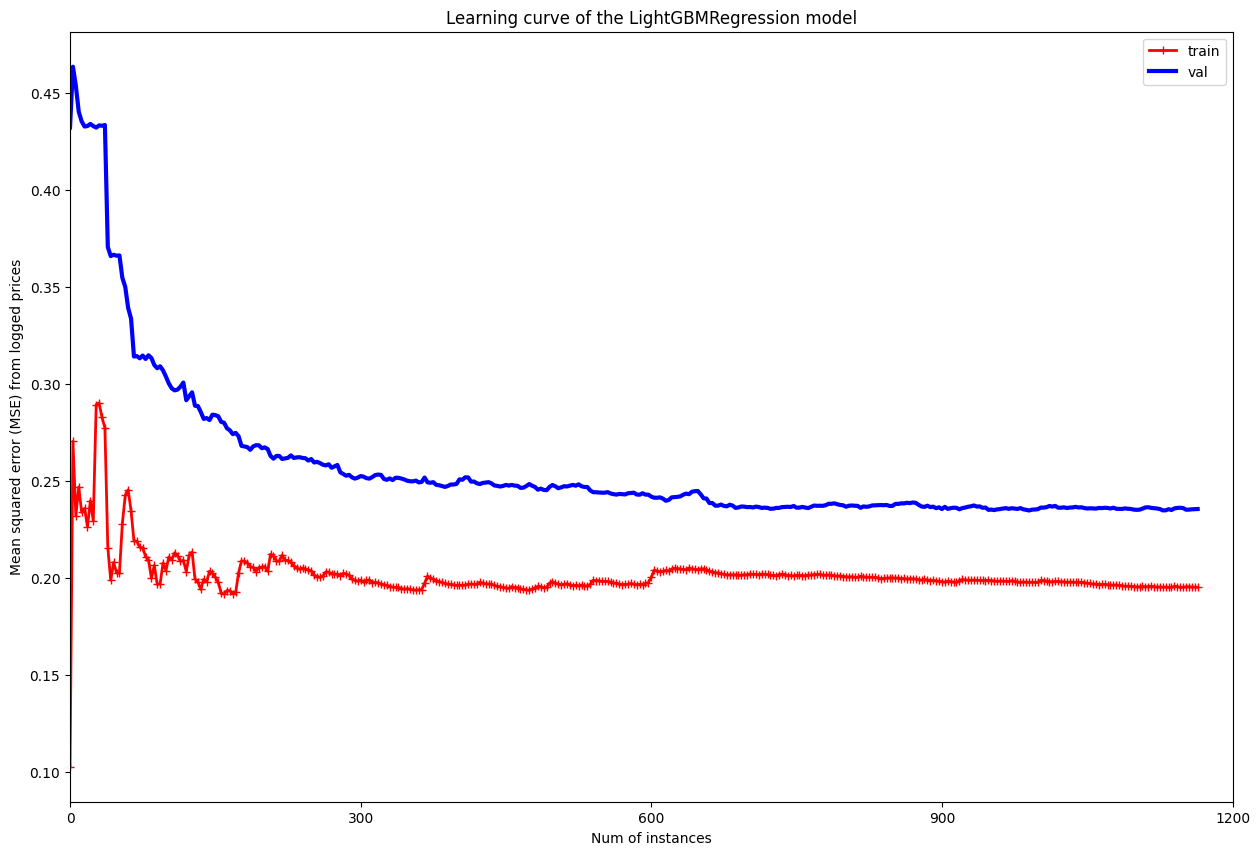

In [39]:
plot_learning_curve(model_name=model_name, lc_train_error=lc_train_error, lc_val_error=lc_val_error)

In [41]:
param_grid = [
    {
        'boosting_type': ['gbdt', 'dart'],
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    },
]
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(learning_rate=0.01, max_depth=5),
             param_grid=[{'boosting_type': ['gbdt', 'dart'],
                          'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
                          'max_depth': [3, 4, 5, 6, 7, 8],
                          'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}],
             return_train_score=True, scoring='neg_mean_squared_error')

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\3719801494.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model.fit(X_t[:m], y_t[:m])
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\3719801494.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_errors.append(mean_squared_error(y_t[:m], y_t_predict))
C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\3719801494.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a fu

LightGBMRegression: optimized linear regression train score = 0.14 +/- 0.07
LightGBMRegression: optimized linear regression val score = 0.17 +/- 0.10


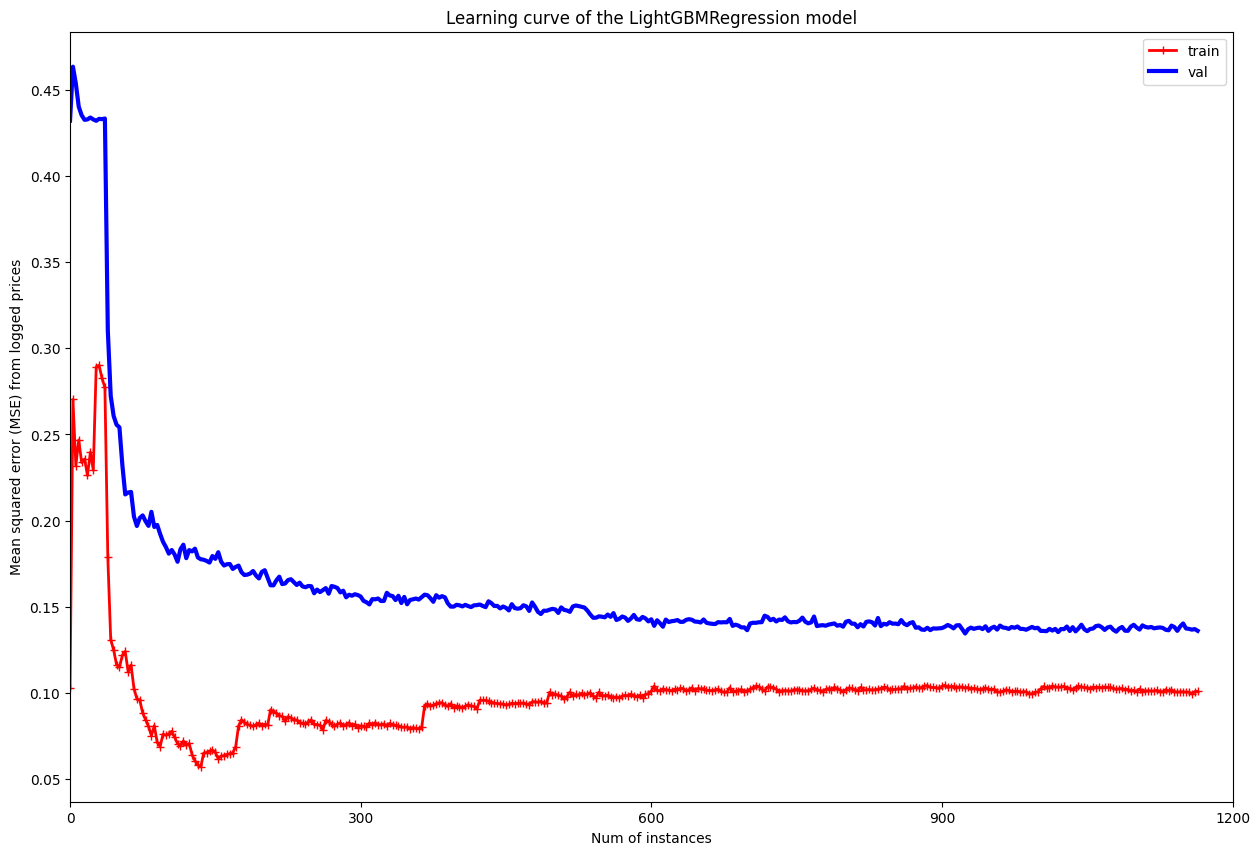

In [42]:
# performing after hyperparams optimization using GridSearchCV or RandomizedSearchCV
model = gscv.best_estimator_
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train, y_train, X_val, y_val)
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: optimized linear regression train score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_train)), np.sqrt(np.std(cv_res_train))))
print('{}: optimized linear regression val score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_val)), np.sqrt(np.std(cv_res_val))))
plot_learning_curve(model_name=model_name, lc_train_error=lc_train_error, lc_val_error=lc_val_error)

In [43]:
df_test = pd.read_csv('datasets/processed/test_sel_feat_boruta.csv', index_col=0)
predictions = np.exp(model.predict(df_test))
df_predictions = pd.Series(predictions, index=df_test.index, name='SalePrice')
df_predictions.info()

<class 'pandas.core.series.Series'>
Int64Index: 1459 entries, 1461 to 2919
Series name: SalePrice
Non-Null Count  Dtype  
--------------  -----  
1459 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In [44]:
df_predictions.to_csv('datasets/test_predictions_v4.csv')

### CatBoost

In [24]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtQual,BsmtFinType1,BsmtFinSF1,TotalBsmtSF,...,AgeBuilt,AgeRemodeled,AgeGarage,MSSubClass_30,MSZoning_C (all),MSZoning_RM,CentralAir_N,CentralAir_Y,GarageType_Attchd,GarageType_Detchd
Id,,,,,,,,,,,,,,,,,,,,,
255,70.0,8400.0,5.0,6.0,1957.0,1957.0,3.0,3.0,922.0,1314.0,...,65.0,65.0,65.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1067,59.0,7837.0,6.0,7.0,1993.0,1994.0,4.0,1.0,0.0,799.0,...,29.0,28.0,29.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
639,67.0,8777.0,5.0,7.0,1910.0,1950.0,2.0,1.0,0.0,796.0,...,112.0,72.0,2022.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
800,60.0,7200.0,5.0,7.0,1937.0,1950.0,4.0,5.0,569.0,731.0,...,85.0,72.0,83.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
381,50.0,5000.0,5.0,6.0,1924.0,1950.0,3.0,2.0,218.0,1026.0,...,98.0,72.0,98.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 255 to 1127
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        1168 non-null   float64
 1   LotArea            1168 non-null   float64
 2   OverallQual        1168 non-null   float64
 3   OverallCond        1168 non-null   float64
 4   YearBuilt          1168 non-null   float64
 5   YearRemodAdd       1168 non-null   float64
 6   BsmtQual           1168 non-null   float64
 7   BsmtFinType1       1168 non-null   float64
 8   BsmtFinSF1         1168 non-null   float64
 9   TotalBsmtSF        1168 non-null   float64
 10  1stFlrSF           1168 non-null   float64
 11  2ndFlrSF           1168 non-null   float64
 12  GrLivArea          1168 non-null   float64
 13  FullBath           1168 non-null   float64
 14  KitchenAbvGr       1168 non-null   float64
 15  KitchenQual        1168 non-null   float64
 16  FireplaceQu        116

In [29]:
cat_features = [
    'OverallQual', 'OverallCond', 'BsmtQual', 'BsmtFinType1',
    'FullBath', 'KitchenQual', 'FireplaceQu', 'MSSubClass_30',
    'MSZoning_C (all)', 'MSZoning_RM', 'CentralAir_N', 'CentralAir_Y',
    'GarageType_Attchd', 'GarageType_Detchd'
]
X_train_cat = X_train.copy()

In [30]:
X_train_cat[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 255 to 1127
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OverallQual        1168 non-null   float64
 1   OverallCond        1168 non-null   float64
 2   BsmtQual           1168 non-null   float64
 3   BsmtFinType1       1168 non-null   float64
 4   FullBath           1168 non-null   float64
 5   KitchenQual        1168 non-null   float64
 6   FireplaceQu        1168 non-null   float64
 7   MSSubClass_30      1168 non-null   float64
 8   MSZoning_C (all)   1168 non-null   float64
 9   MSZoning_RM        1168 non-null   float64
 10  CentralAir_N       1168 non-null   float64
 11  CentralAir_Y       1168 non-null   float64
 12  GarageType_Attchd  1168 non-null   float64
 13  GarageType_Detchd  1168 non-null   float64
dtypes: float64(14)
memory usage: 136.9 KB


In [31]:
X_train_cat[cat_features] = X_train_cat[cat_features].astype('string')
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 255 to 1127
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        1168 non-null   float64
 1   LotArea            1168 non-null   float64
 2   OverallQual        1168 non-null   string 
 3   OverallCond        1168 non-null   string 
 4   YearBuilt          1168 non-null   float64
 5   YearRemodAdd       1168 non-null   float64
 6   BsmtQual           1168 non-null   string 
 7   BsmtFinType1       1168 non-null   string 
 8   BsmtFinSF1         1168 non-null   float64
 9   TotalBsmtSF        1168 non-null   float64
 10  1stFlrSF           1168 non-null   float64
 11  2ndFlrSF           1168 non-null   float64
 12  GrLivArea          1168 non-null   float64
 13  FullBath           1168 non-null   string 
 14  KitchenAbvGr       1168 non-null   float64
 15  KitchenQual        1168 non-null   string 
 16  FireplaceQu        116

In [32]:
X_val_cat = X_val.copy()
X_val_cat[cat_features] = X_val_cat[cat_features].astype('string')
X_val_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 893 to 723
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        292 non-null    float64
 1   LotArea            292 non-null    float64
 2   OverallQual        292 non-null    string 
 3   OverallCond        292 non-null    string 
 4   YearBuilt          292 non-null    float64
 5   YearRemodAdd       292 non-null    float64
 6   BsmtQual           292 non-null    string 
 7   BsmtFinType1       292 non-null    string 
 8   BsmtFinSF1         292 non-null    float64
 9   TotalBsmtSF        292 non-null    float64
 10  1stFlrSF           292 non-null    float64
 11  2ndFlrSF           292 non-null    float64
 12  GrLivArea          292 non-null    float64
 13  FullBath           292 non-null    string 
 14  KitchenAbvGr       292 non-null    float64
 15  KitchenQual        292 non-null    string 
 16  FireplaceQu        292 n

In [33]:
model_name = 'CatBoostRegression'
train_pool = ctb.Pool(
    X_train_cat, y_train,
    cat_features=cat_features
)
model = ctb.CatBoostRegressor(learning_rate=0.01, max_depth=5, subsample=1.0, loss_function='RMSE') # subsample -> [0.5, 0.8] compare to 1.0 results
model.fit(X_train_cat, y_train)
# getting baseline scores
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train_cat, y_train, X_val_cat, y_val)
cv_res_train = cross_val_score(model, X_train_cat, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val_cat, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: baseline regression train score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_train)), np.sqrt(np.std(cv_res_train))))
print('{}: baseline regression val score = {:.2f} +/- {:.2f}'.format(model_name, np.sqrt(-np.mean(cv_res_val)), np.sqrt(np.std(cv_res_val))))

0:	learn: 0.3880417	total: 408ms	remaining: 6m 48s
1:	learn: 0.3855184	total: 410ms	remaining: 3m 24s
2:	learn: 0.3830674	total: 417ms	remaining: 2m 18s
3:	learn: 0.3805720	total: 421ms	remaining: 1m 44s
4:	learn: 0.3781713	total: 423ms	remaining: 1m 24s
5:	learn: 0.3756748	total: 424ms	remaining: 1m 10s
6:	learn: 0.3732235	total: 426ms	remaining: 1m
7:	learn: 0.3708229	total: 430ms	remaining: 53.4s
8:	learn: 0.3684554	total: 434ms	remaining: 47.8s
9:	learn: 0.3660974	total: 436ms	remaining: 43.2s
10:	learn: 0.3637759	total: 438ms	remaining: 39.3s
11:	learn: 0.3614465	total: 439ms	remaining: 36.2s
12:	learn: 0.3591631	total: 441ms	remaining: 33.5s
13:	learn: 0.3570524	total: 446ms	remaining: 31.4s
14:	learn: 0.3548644	total: 451ms	remaining: 29.6s
15:	learn: 0.3527177	total: 453ms	remaining: 27.8s
16:	learn: 0.3505170	total: 455ms	remaining: 26.3s
17:	learn: 0.3482672	total: 456ms	remaining: 24.9s
18:	learn: 0.3462179	total: 460ms	remaining: 23.8s
19:	learn: 0.3439934	total: 465ms	rema

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_7344\2669310395.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model.fit(X_t[:m], y_t[:m])


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2416: All features are either constant or ignored.

### RandomForest

## Linear models class

### General Linear Regression

In [14]:
model_name = 'LinearRegression'
model = LinearRegression()
model.fit(X_train, y_train)
# getting baseline scores
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: baseline linear regression train score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_train), np.std(cv_res_train)))
print('{}: baseline linear regression val score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_val), np.std(cv_res_val)))

In [18]:
# filling base characteristics
models_results['model_name'].append(model_name)
models_results['model'].append(model)
models_results['x_scaled'] = False
models_results['baseline_mean_train'].append(-np.mean(cv_res_train))
models_results['baseline_std_train'].append(np.std(cv_res_train))
models_results['baseline_mean_val'].append(-np.mean(cv_res_val))
models_results['baseline_std_val'].append(np.std(cv_res_val))

In [17]:
# performing after hyperparams optimization using GridSearchCV or RandomizedSearchCV
#model = gscv.best_estimator_
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train, y_train, X_val, y_val)
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
print('{}: optimized linear regression train score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_train), np.std(cv_res_train)))
print('{}: optimized linear regression val score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_val), np.std(cv_res_val)))

In [ ]:
# filling optimized characteristics
models_results['learn_curve_train'].append(lc_train_error)
models_results['learn_curve_val'].append(lc_val_error)
models_results['opt_mean_train'].append(models_results['baseline_mean_train'])
models_results['opt_std_train'].append(models_results['baseline_std_train'])
models_results['opt_mean_val'].append(models_results['baseline_mean_val'])
models_results['opt_std_val'].append(models_results['baseline_std_val'])
models_results['param_search_res'].append(None)
models_results['opt_model'].append(None)

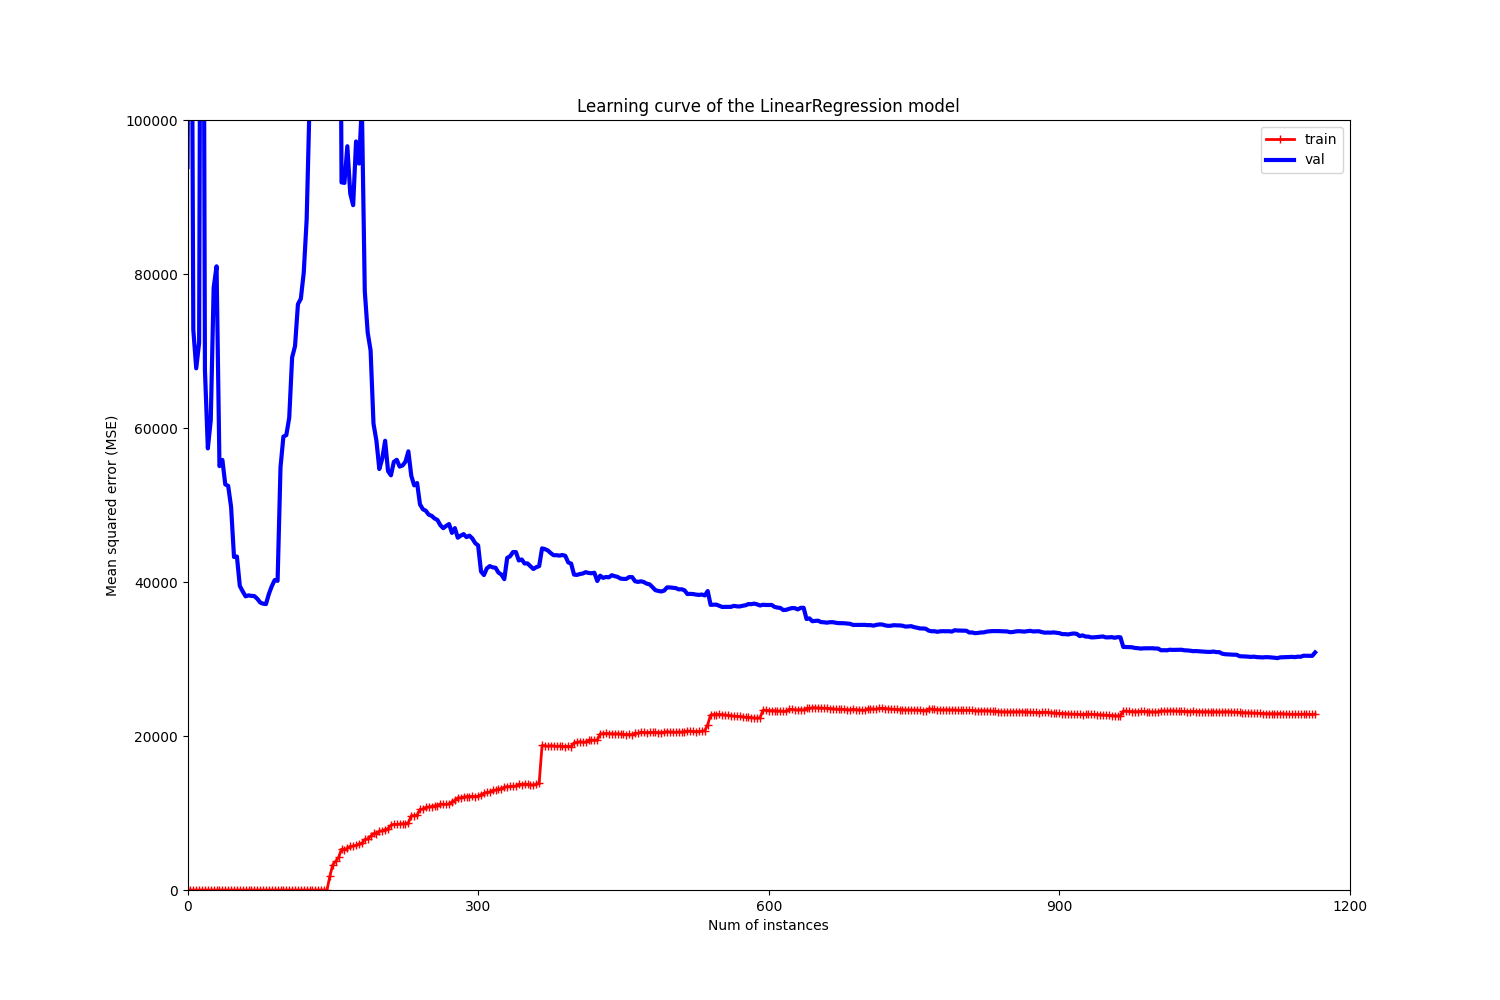

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(lc_train_error), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(lc_val_error), "b-", linewidth=3, label="val")
plt.legend()
plt.title(f'Learning curve of the {model_name} model')
ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(lc_train_error)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
ax.set_xticks(range(0, upper_x_bound+1, 100))
ax.set_xticklabels([str(3*x) for x in range(0, upper_x_bound+1, 100)]);

### Ridge Regression

In [25]:
model_name = 'Ridge'
model = Ridge() #alpha=1.0

In [26]:
model.fit(X_train_scaled, y_train)

Ridge()

In [27]:
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')

In [32]:
models_results['model_name'].append(model_name)
models_results['model'].append(model)
models_results['x_scaled'] = True
models_results['baseline_mean_train'].append(-np.mean(cv_res_train))
models_results['baseline_std_train'].append(np.std(cv_res_train))
models_results['baseline_mean_val'].append(-np.mean(cv_res_val))
models_results['baseline_std_val'].append(np.std(cv_res_val))
models_results['learn_curve_train'].append(lc_train_error)
models_results['learn_curve_val'].append(lc_val_error)
models_results['opt_mean_train'].append(models_results['baseline_mean_train'])
models_results['opt_std_train'].append(models_results['baseline_std_train'])
models_results['opt_mean_val'].append(models_results['baseline_mean_val'])
models_results['opt_std_val'].append(models_results['baseline_std_val'])
models_results['param_search_res'].append(gscv.cv_results_)
models_results['opt_model'].append(gscv.best_estimator_)

In [29]:
param_grid = {
    'alpha': [0, 1e-3, 0.1, 1, 10, 100, 1000]
}
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
gscv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 0.001, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [33]:
print('{}: baseline linear regression train score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_train), np.std(cv_res_train)))
print('{}: baseline linear regression val score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_val), np.std(cv_res_val)))

Ridge: baseline linear regression train score = 1220934863.3960 +/- 643431269.7526
Ridge: baseline linear regression val score = 1547663436.3230 +/- 581976102.9812


In [34]:
model = gscv.best_estimator_
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train_scaled, y_train, X_val_scaled, y_val)

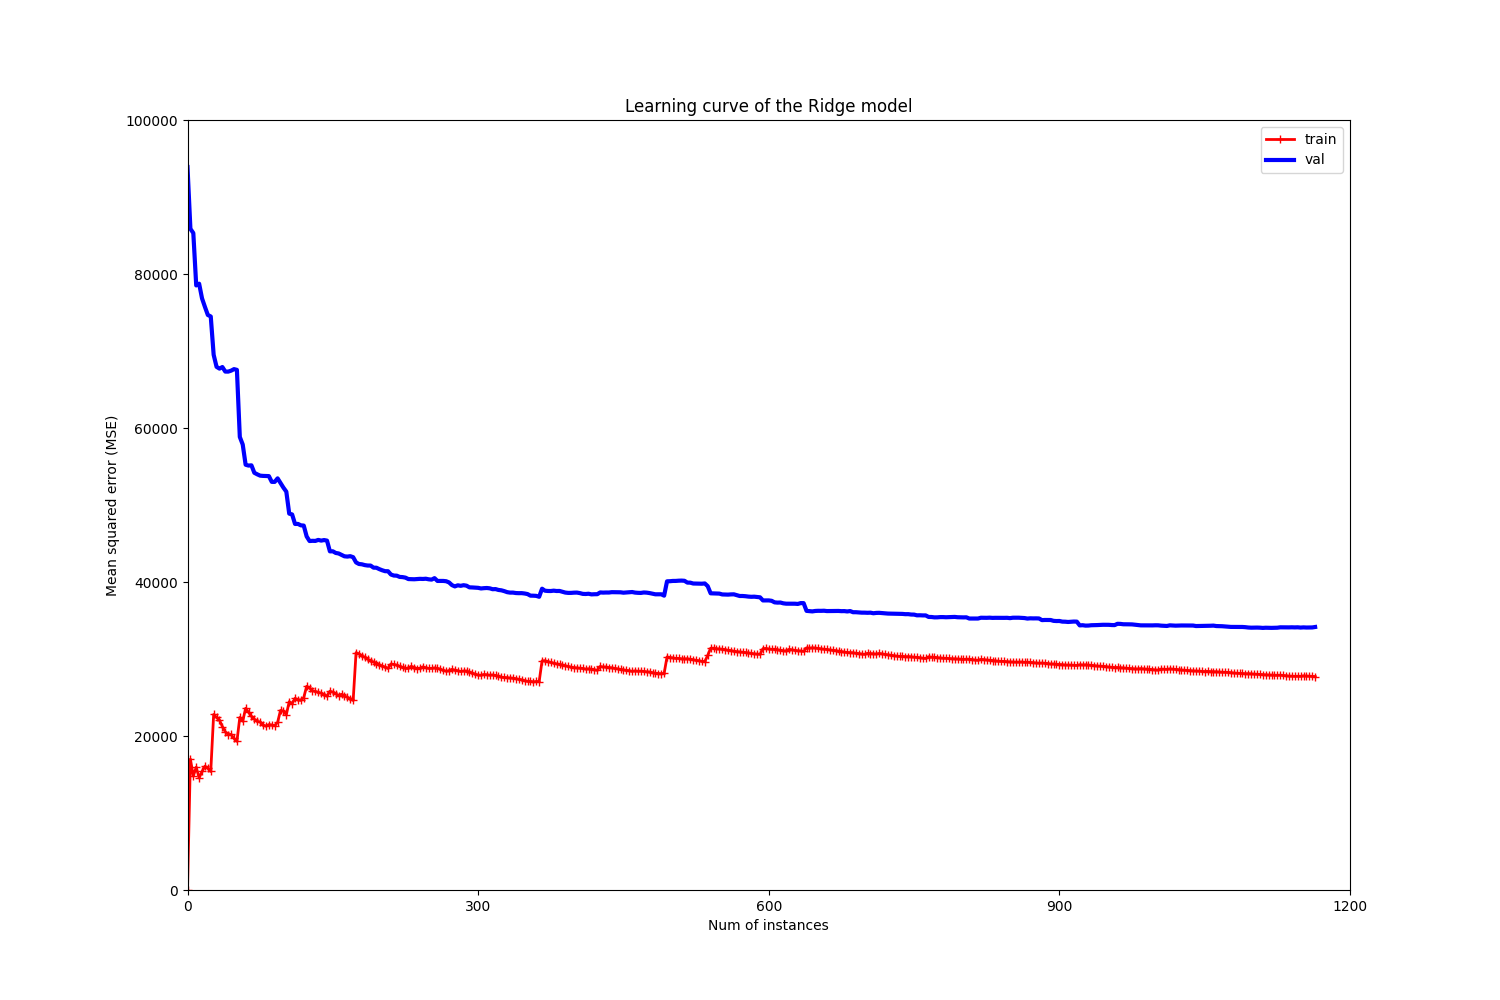

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(lc_train_error), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(lc_val_error), "b-", linewidth=3, label="val")
plt.legend()
plt.title(f'Learning curve of the {model_name} model')
ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(lc_train_error)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
ax.set_xticks(range(0, upper_x_bound+1, 100))
ax.set_xticklabels([str(3*x) for x in range(0, upper_x_bound+1, 100)]);

### Stochastic Gradient Descent (SGD)

In [40]:
model_name = 'SGD'
model = SGDRegressor(loss='huber', max_iter=10000)
# penalty='l2'|'l1'|'elasticnet'
# loss = 'squared_error'|'huber'|'epsilon_insensitive' - last 2 gives more robust results
# more params see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

In [41]:
model.fit(X_train_scaled, y_train)

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(loss='huber', max_iter=10000)

In [42]:
cv_res_train = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val_scaled, y_val, cv=5, scoring='neg_mean_squared_error')

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\

In [45]:
print('{}: baseline linear regression train score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_train), np.std(cv_res_train)))
print('{}: baseline linear regression val score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_val), np.std(cv_res_val)))

SGD: baseline linear regression train score = 36972824284.2627 +/- 1238960675.8791
SGD: baseline linear regression val score = 38946197797.7381 +/- 7161500676.1447


In [43]:
models_results['model_name'].append(model_name)
models_results['model'].append(model)
models_results['x_scaled'] = True
models_results['baseline_mean_train'].append(-np.mean(cv_res_train))
models_results['baseline_std_train'].append(np.std(cv_res_train))
models_results['baseline_mean_val'].append(-np.mean(cv_res_val))
models_results['baseline_std_val'].append(np.std(cv_res_val))

In [44]:
param_grid = {
    'loss': ['huber'],
    'alpha': [1e-5, 1e-4, 1e-3],
    
}
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
gscv.fit(X_train_scaled, y_train)

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\

GridSearchCV(cv=5, estimator=SGDRegressor(loss='huber', max_iter=10000),
             param_grid={'alpha': [1e-05, 0.0001, 0.001], 'loss': ['huber']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [46]:
model = gscv.best_estimator_
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train_scaled, y_train, X_val_scaled, y_val)

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\

In [47]:
cv_res_train = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val_scaled, y_val, cv=5, scoring='neg_mean_squared_error')

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\

In [48]:
models_results['learn_curve_train'].append(lc_train_error)
models_results['learn_curve_val'].append(lc_val_error)
models_results['opt_mean_train'].append(-np.mean(cv_res_train))
models_results['opt_std_train'].append(np.std(cv_res_train))
models_results['opt_mean_val'].append(-np.mean(cv_res_val))
models_results['opt_std_val'].append(np.std(cv_res_val))
models_results['param_search_res'].append(gscv.cv_results_)
models_results['opt_model'].append(gscv.best_estimator_)

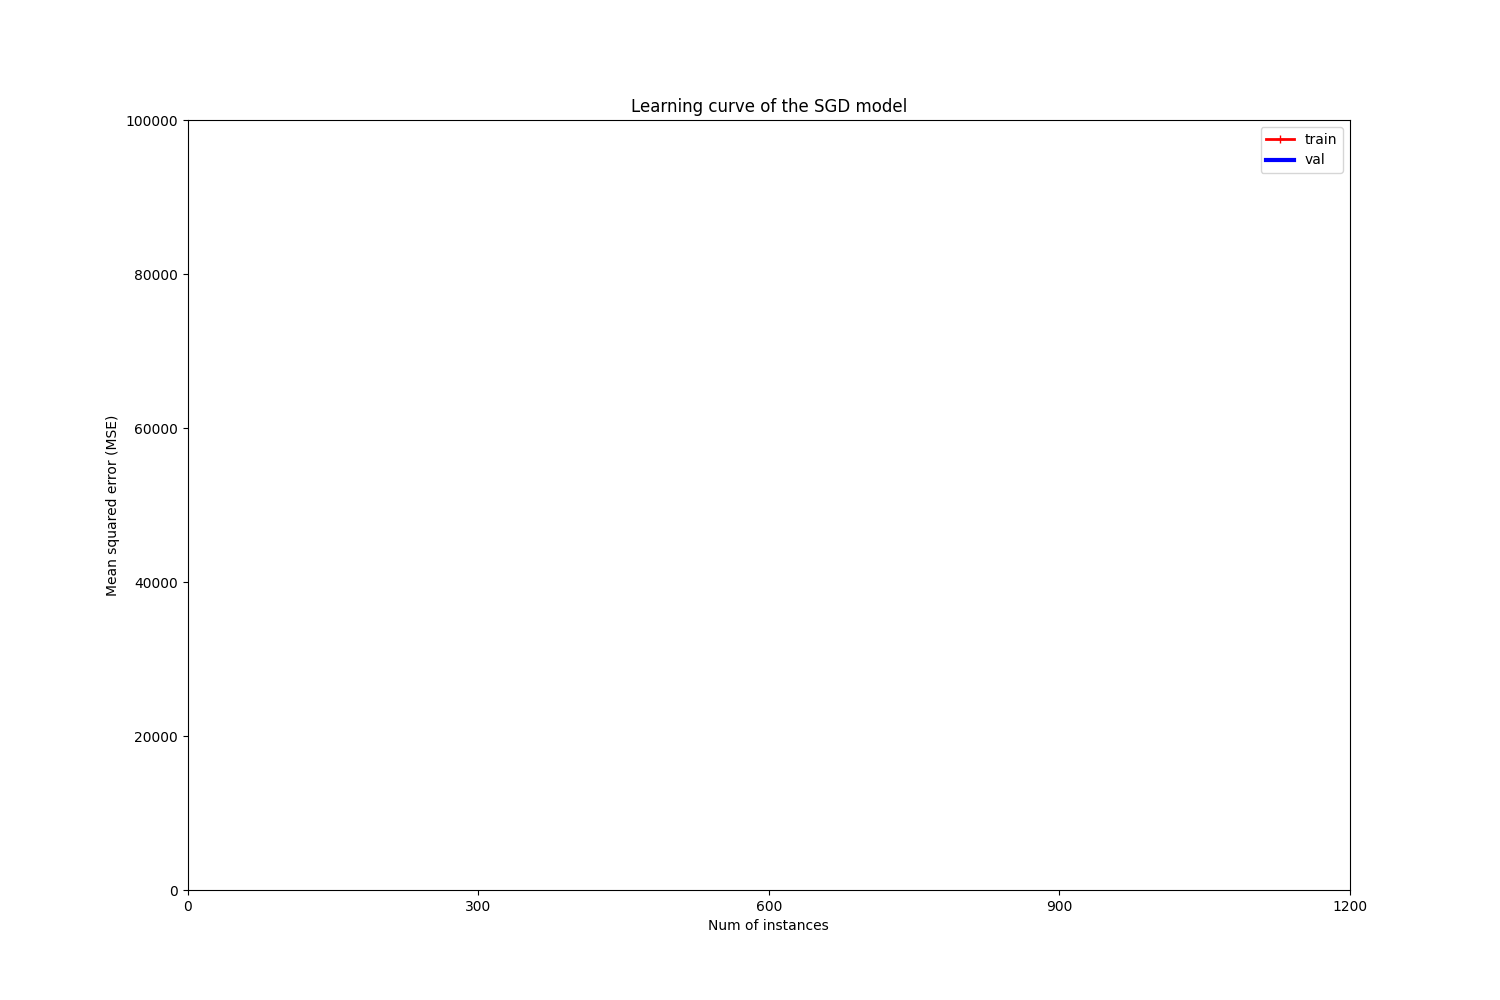

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(lc_train_error), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(lc_val_error), "b-", linewidth=3, label="val")
plt.legend()
plt.title(f'Learning curve of the {model_name} model')
ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(lc_train_error)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
ax.set_xticks(range(0, upper_x_bound+1, 100))
ax.set_xticklabels([str(3*x) for x in range(0, upper_x_bound+1, 100)]);

### ElasticNet

In [50]:
model_name = 'ElasticNet'
model = ElasticNet(alpha=1.0, l1_ratio=0.5, )

In [51]:
model.fit(X_train_scaled, y_train)

ElasticNet()

In [52]:
cv_res_train = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.416e+11, tolerance: 5.374e+08
  model = cd_fast.enet_coordinate_descent(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.368e+11, tolerance: 5.720e+08
  model = cd_fast.enet_coordinate_descent(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.057e+11, toler

In [53]:
print('{}: baseline linear regression train score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_train), np.std(cv_res_train)))
print('{}: baseline linear regression val score = {:.4f} +/- {:.4f}'.format(model_name, -np.mean(cv_res_val), np.std(cv_res_val)))

ElasticNet: baseline linear regression train score = 1451343864.1756 +/- 888719199.5979
ElasticNet: baseline linear regression val score = 1305387723.3316 +/- 697332227.1778


In [54]:
models_results['model_name'].append(model_name)
models_results['model'].append(model)
models_results['x_scaled'] = True
models_results['baseline_mean_train'].append(-np.mean(cv_res_train))
models_results['baseline_std_train'].append(np.std(cv_res_train))
models_results['baseline_mean_val'].append(-np.mean(cv_res_val))
models_results['baseline_std_val'].append(np.std(cv_res_val))

In [55]:
param_grid = [
    {
        'l1_ratio': [x/10 for x in range(0, 11)],
        'alpha': [x/10 for x in range(1, 11)]
    },
]
gscv = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
gscv.fit(X_train_scaled, y_train)

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.767e+11, tolerance: 5.374e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.612e+11, tolerance: 5.720e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid=[{'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    1.0],
                          'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                       0.8, 0.9, 1.0]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [56]:
model = gscv.best_estimator_
lc_train_error, lc_val_error = get_learning_curve_data(model, X_train_scaled, y_train, X_val_scaled, y_val)

d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.927e+06, tolerance: 5.587e+05
  model = cd_fast.enet_coordinate_descent(
d:\Work\venv\DataAnalysis\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e+07, toler

In [57]:
cv_res_train = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_res_val = cross_val_score(model, X_val_scaled, y_val, cv=5, scoring='neg_mean_squared_error')

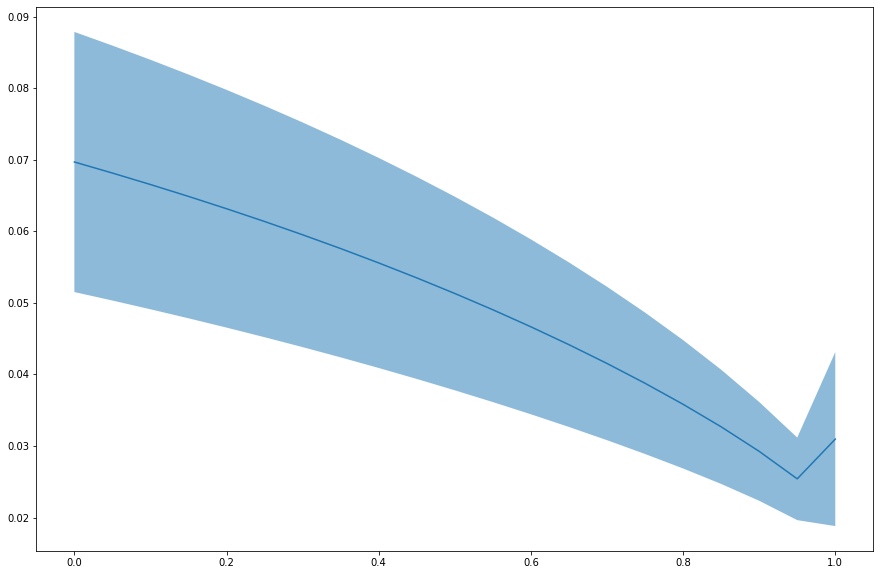

In [45]:
"""
upper_bound = -gscv_elnet_res['mean_test_score'] + gscv_elnet_res['std_test_score']
lower_bound = -gscv_elnet_res['mean_test_score'] - gscv_elnet_res['std_test_score']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(param_x, -gscv_elnet_res['mean_test_score'])
plt.fill_between(param_x, upper_bound, lower_bound, alpha=0.5)
#ax.set_ybound(lower=0.0, upper=0.05);
#plt.xticks(range(0, 1001, 100));
"""

In [58]:
models_results['learn_curve_train'].append(lc_train_error)
models_results['learn_curve_val'].append(lc_val_error)
models_results['opt_mean_train'].append(-np.mean(cv_res_train))
models_results['opt_std_train'].append(np.std(cv_res_train))
models_results['opt_mean_val'].append(-np.mean(cv_res_val))
models_results['opt_std_val'].append(np.std(cv_res_val))
models_results['param_search_res'].append(gscv.cv_results_)
models_results['opt_model'].append(gscv.best_estimator_)

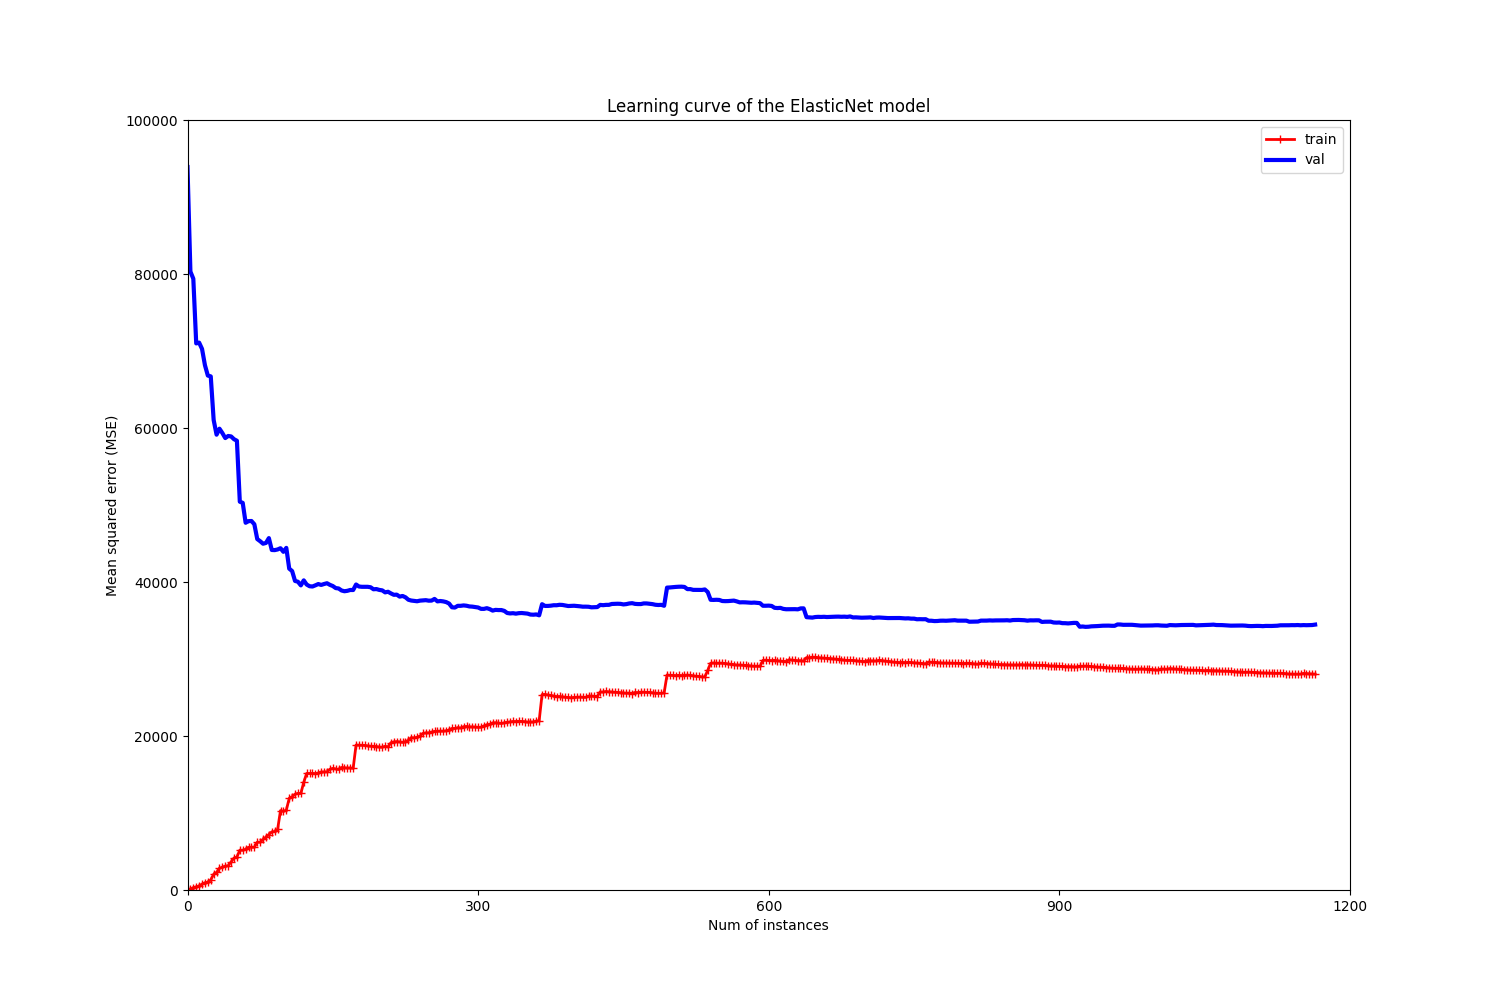

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(lc_train_error), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(lc_val_error), "b-", linewidth=3, label="val")
plt.legend()
plt.title(f'Learning curve of the {model_name} model')
ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(lc_train_error)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
ax.set_xticks(range(0, upper_x_bound+1, 100))
ax.set_xticklabels([str(3*x) for x in range(0, upper_x_bound+1, 100)]);

In [51]:
"""
elnet_reg = ElasticNet(l1_ratio=0.95)

param_grid = [
    {'l1_ratio': [0.95], 'alpha': [x/100 for x in range(0, 101, 5)]},
]

gscv_elnet = GridSearchCV(estimator=elnet_reg, param_grid=param_grid, cv=10, scoring='neg_mean_squared_log_error', return_train_score=True)

gscv_elnet.fit(X_train_scaled, y_train)
gscv_elnet_res = gscv_elnet.cv_results_

param_x = [x['alpha'] for x in gscv_elnet_res['params']]

upper_bound = -gscv_elnet_res['mean_test_score'] + gscv_elnet_res['std_test_score']
lower_bound = -gscv_elnet_res['mean_test_score'] - gscv_elnet_res['std_test_score']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(param_x, -gscv_elnet_res['mean_test_score'])
plt.fill_between(param_x, upper_bound, lower_bound, alpha=0.5)
#ax.set_ybound(lower=0.0, upper=0.05);
#plt.xticks(range(0, 1001, 100));
"""

21

## Support Vector class

### LinearSVR

Has to be trained on scaled versions of X

In [11]:
linsvr_reg = LinearSVR(epsilon=0.1, C=1)

In [12]:
linsvr_reg.fit(X_train_scaled, y_train)

LinearSVR(C=1, epsilon=0.1)

In [14]:
print('Train error: {:.4f}'.format(mean_squared_log_error(y_train, linsvr_reg.predict(X_train_scaled))))
print('Test error: {:.4f}'.format(mean_squared_log_error(y_test, linsvr_reg.predict(X_test_scaled))))

Train error: 3.0718
Test error: 2.9896


In [15]:
grid_params = [
    {'epsilon': [0.01, 0.1, 0.5, 1, 5, 10], 'C': [0.01, 0.1, 1, 10, 100]},
]
gscv_linsvr = GridSearchCV(estimator=linsvr_reg, param_grid=grid_params, cv=5, scoring='neg_mean_squared_log_error', return_train_score=True)

In [16]:
gscv_linsvr.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LinearSVR(C=1, epsilon=0.1),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'epsilon': [0.01, 0.1, 0.5, 1, 5, 10]}],
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [19]:
linsvr_reg = gscv_linsvr.best_estimator_

In [20]:
train_errors, val_errors = get_learning_curve_data(linsvr_reg, X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)

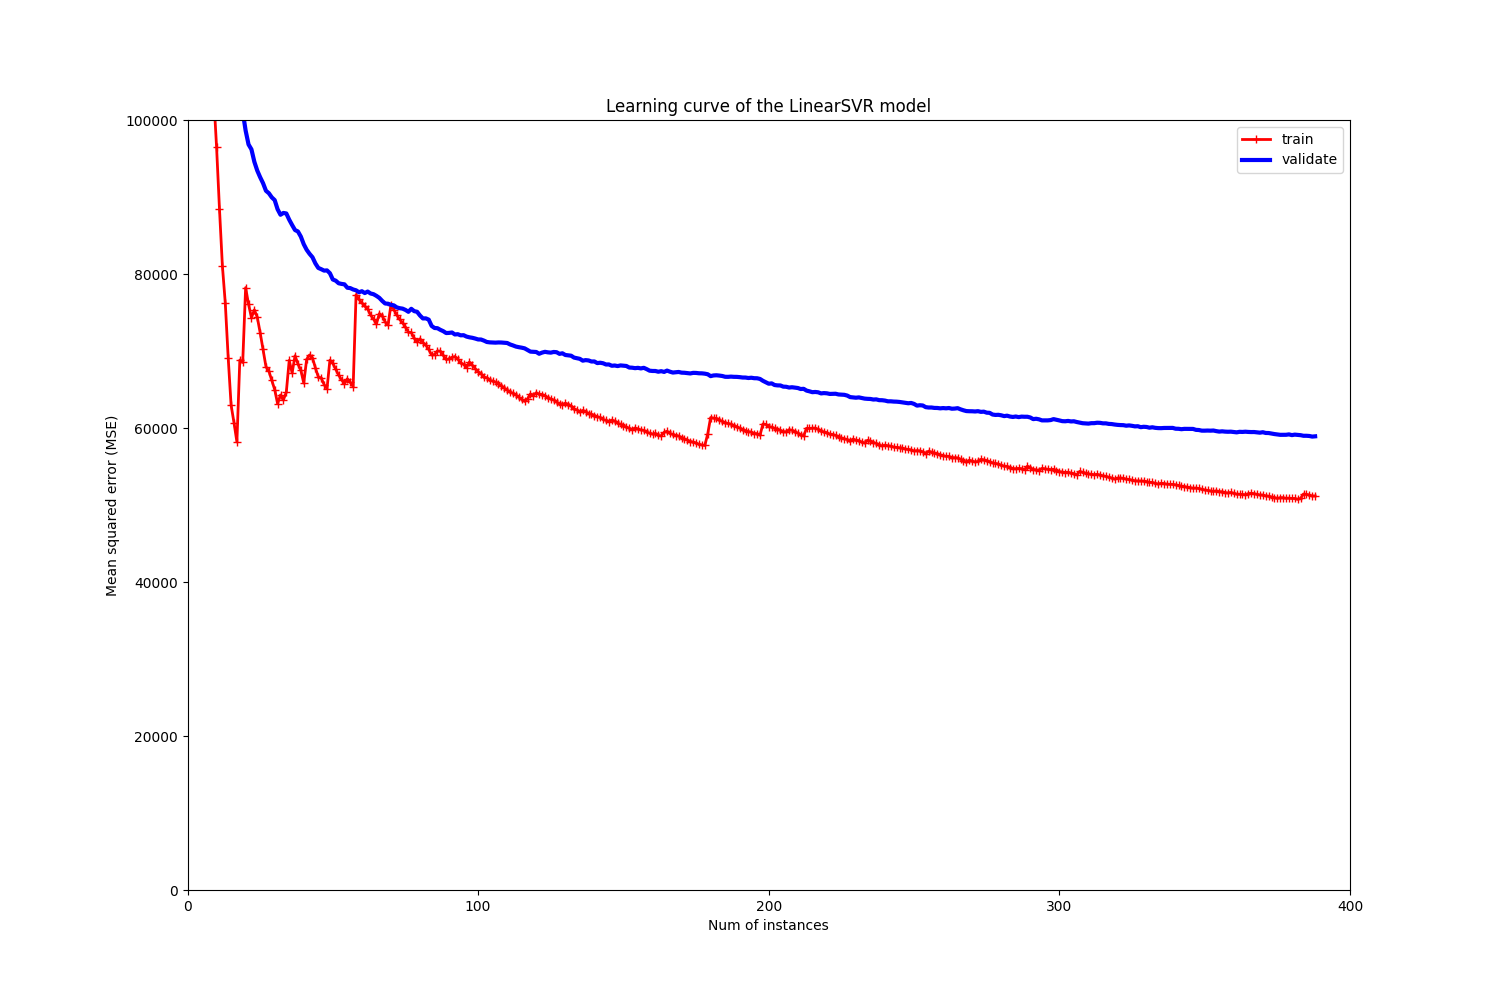

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validate")
plt.legend()
plt.title('Learning curve of the LinearSVR model')
ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(train_errors)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
plt.xticks(range(0, upper_x_bound+1, 100));

In [22]:
gensvr_reg = SVR(kernel='rbf', epsilon=0.1, C=1)

In [23]:
gensvr_reg = gensvr_reg.fit(X_train_scaled, y_train)

In [24]:
grid_params = [
    {'epsilon': [0.01, 0.1, 0.5, 1, 5, 10], 'C': [0.01, 0.1, 1, 10, 100]},
]
gscv_gensvr = GridSearchCV(estimator=linsvr_reg, param_grid=grid_params, cv=5, scoring='neg_mean_squared_log_error', return_train_score=True)
gscv_gensvr.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LinearSVR(C=100, epsilon=0.1),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'epsilon': [0.01, 0.1, 0.5, 1, 5, 10]}],
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [25]:
gensvr_reg = gscv_gensvr.best_estimator_

In [26]:
train_errors, val_errors = get_learning_curve_data(gensvr_reg, X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)

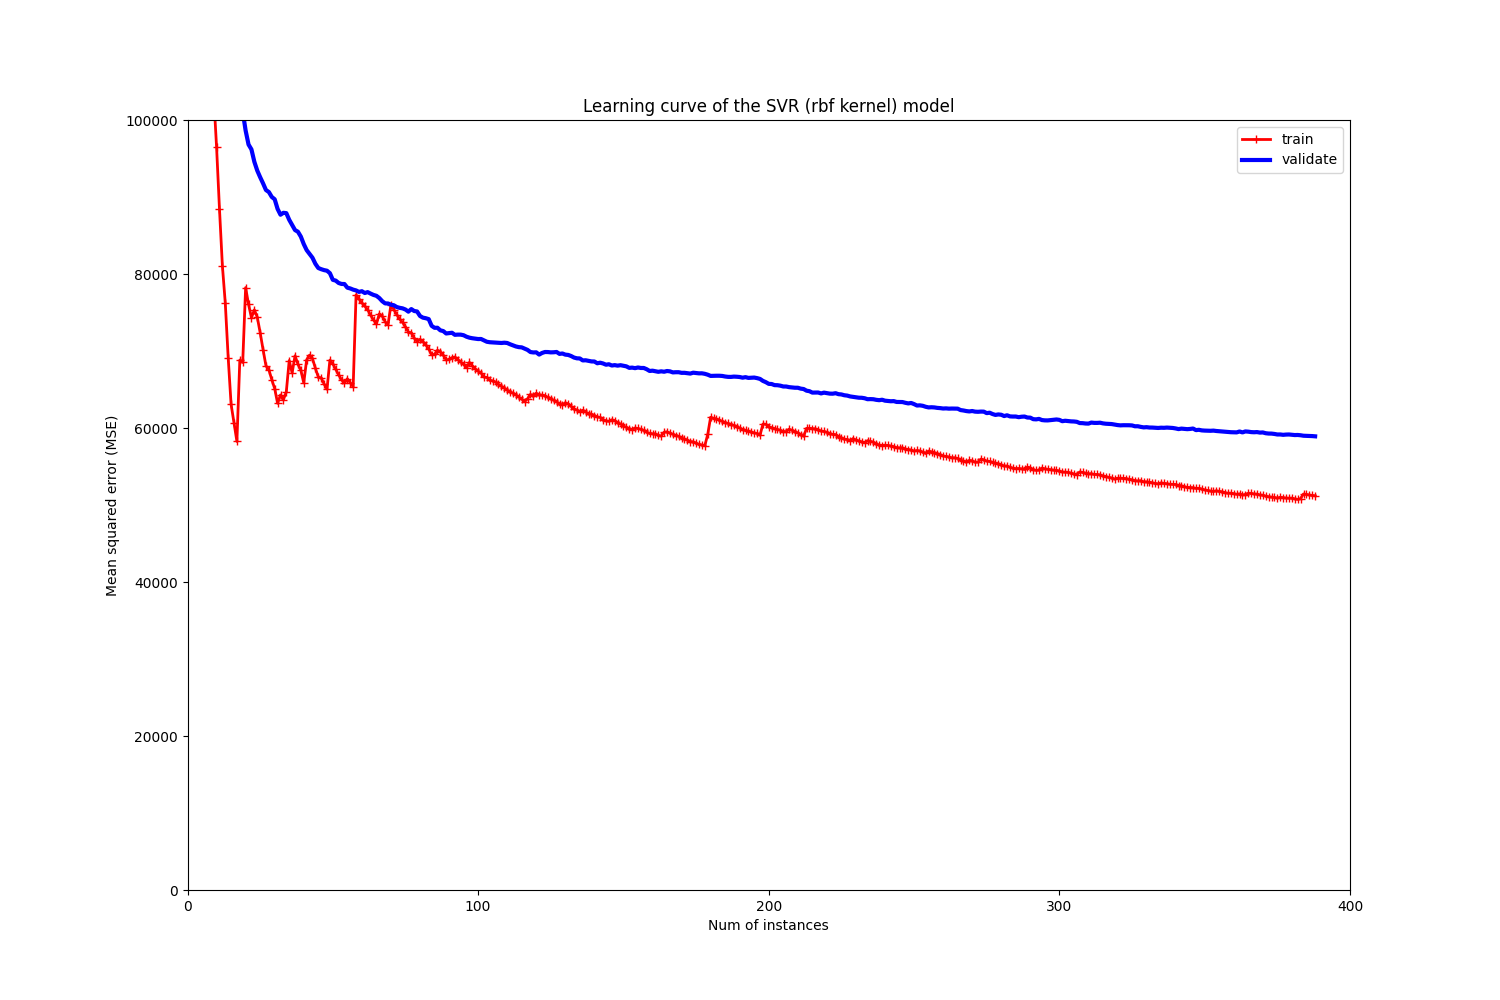

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validate")
plt.legend()
plt.title('Learning curve of the SVR (rbf kernel) model')
ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(train_errors)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
plt.xticks(range(0, upper_x_bound+1, 100));

## Experimenting with Forest models

In [29]:
rforest_reg = RandomForestRegressor(n_estimators=100)

In [30]:
rforest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [31]:
param_grid = [
    {'n_estimators': [10, 50, 100, 500, 1000, 2000], 'max_features': [2, 6, 10, 14, 18, 22],},
    {'bootstrap': [False], 'n_estimators': [10, 50, 100, 500, 1000, 1200], 'max_features': [2, 6, 10, 14, 18, 22]},
]
gscv_rforest = GridSearchCV(estimator=rforest_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_log_error', return_train_score=True)
gscv_rforest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 6, 10, 14, 18, 22],
                          'n_estimators': [10, 50, 100, 500, 1000, 2000]},
                         {'bootstrap': [False],
                          'max_features': [2, 6, 10, 14, 18, 22],
                          'n_estimators': [10, 50, 100, 500, 1000, 2000]}],
             return_train_score=True, scoring='neg_mean_squared_log_error')

In [32]:
rforest_reg = gscv_rforest.best_estimator_

In [33]:
train_errors, val_errors = get_learning_curve_data(rforest_reg, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

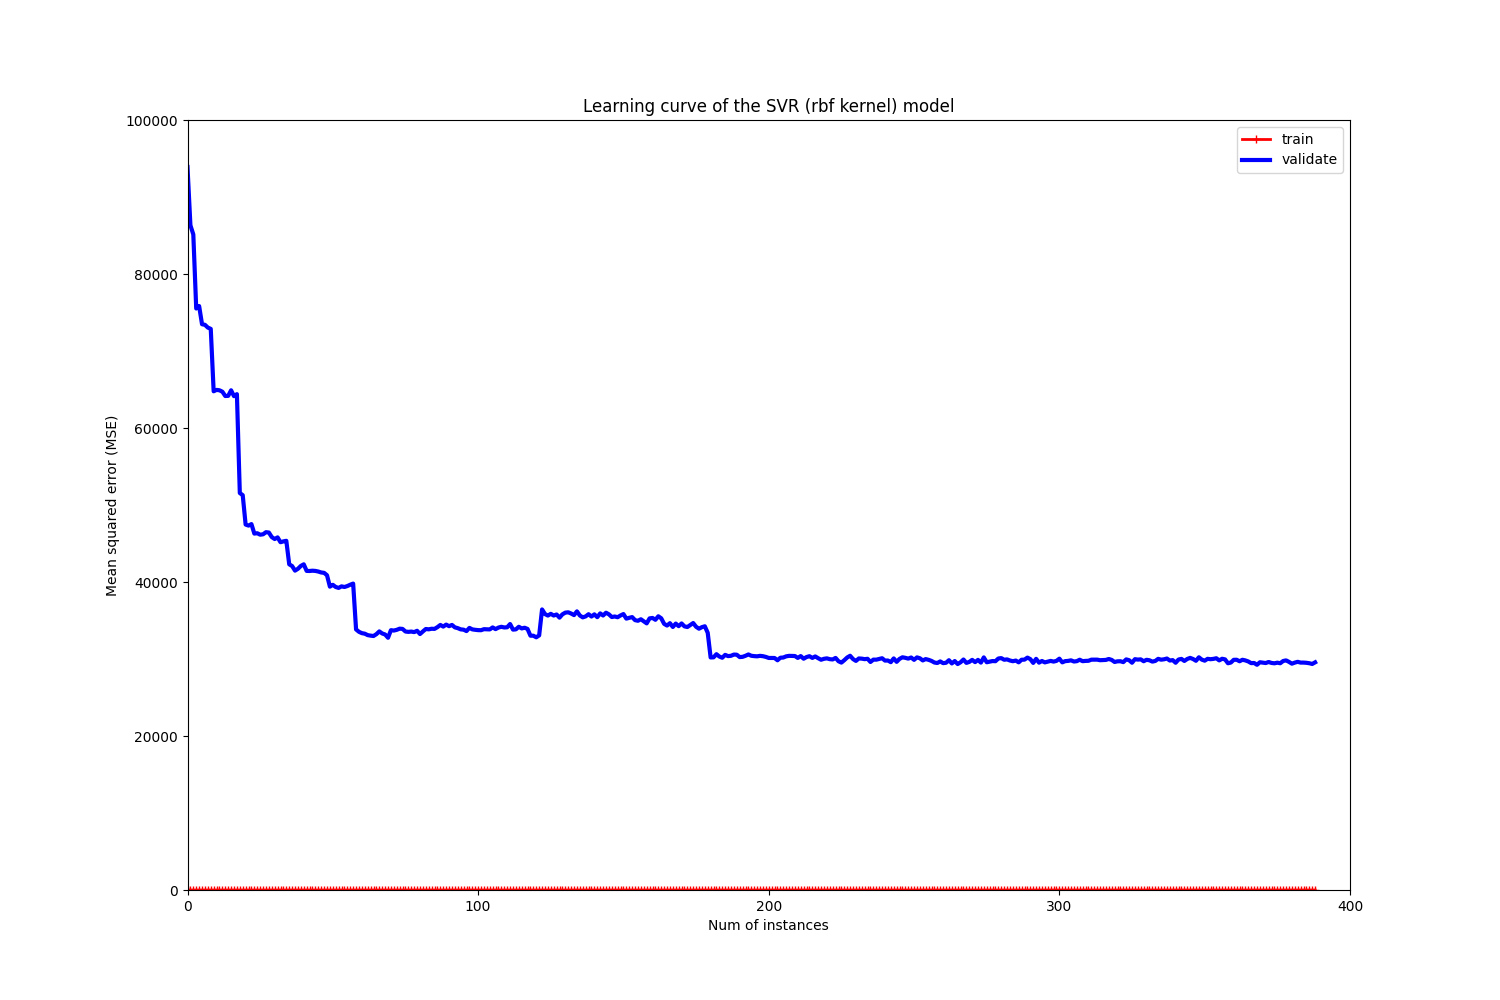

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validate")
plt.legend()
plt.title('Learning curve of the SVR (rbf kernel) model')
ax.set_ybound(lower=0.0, upper=1e5)
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(train_errors)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
plt.xticks(range(0, upper_x_bound+1, 100));

In [36]:
rforest_reg.feature_importances_

array([1.18364011e-02, 2.26081643e-02, 2.49019517e-03, 1.22060162e-03,
       9.78053107e-02, 3.70402803e-03, 3.41686509e-02, 1.28922115e-02,
       1.05751925e-02, 4.99962509e-02, 9.05498319e-04, 3.80466434e-02,
       1.09112066e-03, 4.41010556e-03, 6.25374040e-03, 2.77015535e-02,
       9.85224599e-04, 1.12378687e-03, 7.02433589e-03, 4.74166434e-02,
       6.27658217e-03, 4.50149634e-02, 2.64002040e-02, 5.69844406e-04,
       7.97277447e-02, 3.06375279e-03, 2.23370544e-04, 1.97210400e-02,
       2.84638483e-03, 5.70670247e-03, 9.09356447e-04, 3.34043574e-02,
       1.70305598e-02, 9.25894060e-04, 1.54596660e-02, 1.94062420e-02,
       2.18634670e-02, 1.49147973e-02, 5.94057857e-02, 3.90422590e-02,
       1.82775795e-03, 1.53954959e-03, 5.03587746e-04, 5.97843354e-03,
       9.44073472e-03, 1.00474365e-03, 3.03982165e-04, 2.10489427e-03,
       2.62333295e-03, 2.24582694e-03, 1.52798969e-03, 1.83293799e-04,
       3.39980278e-03, 1.98515505e-03, 0.00000000e+00, 0.00000000e+00,
      

In [88]:
rforest_gridseearch_params = {'n_estimators': [], 'max_features': [], 'mean_test_score': [], 'std_test_score': []}
for i, d in enumerate(gscv_rforest.cv_results_['params']):
    rforest_gridseearch_params['n_estimators'].append(d['n_estimators'])
    rforest_gridseearch_params['max_features'].append(d['max_features'])
    rforest_gridseearch_params['mean_test_score'].append(-gscv_rforest.cv_results_['mean_test_score'][i])
    rforest_gridseearch_params['std_test_score'].append(gscv_rforest.cv_results_['std_test_score'][i])

In [89]:
df_rforest_gridsearch = pd.DataFrame(rforest_gridseearch_params)
df_rforest_gridsearch.head()

,n_estimators,max_features,mean_test_score,std_test_score
0,10,2,0.035919,0.008136
1,50,2,0.029981,0.007584
2,100,2,0.029103,0.008564
3,500,2,0.029042,0.007802
4,1000,2,0.028501,0.007743


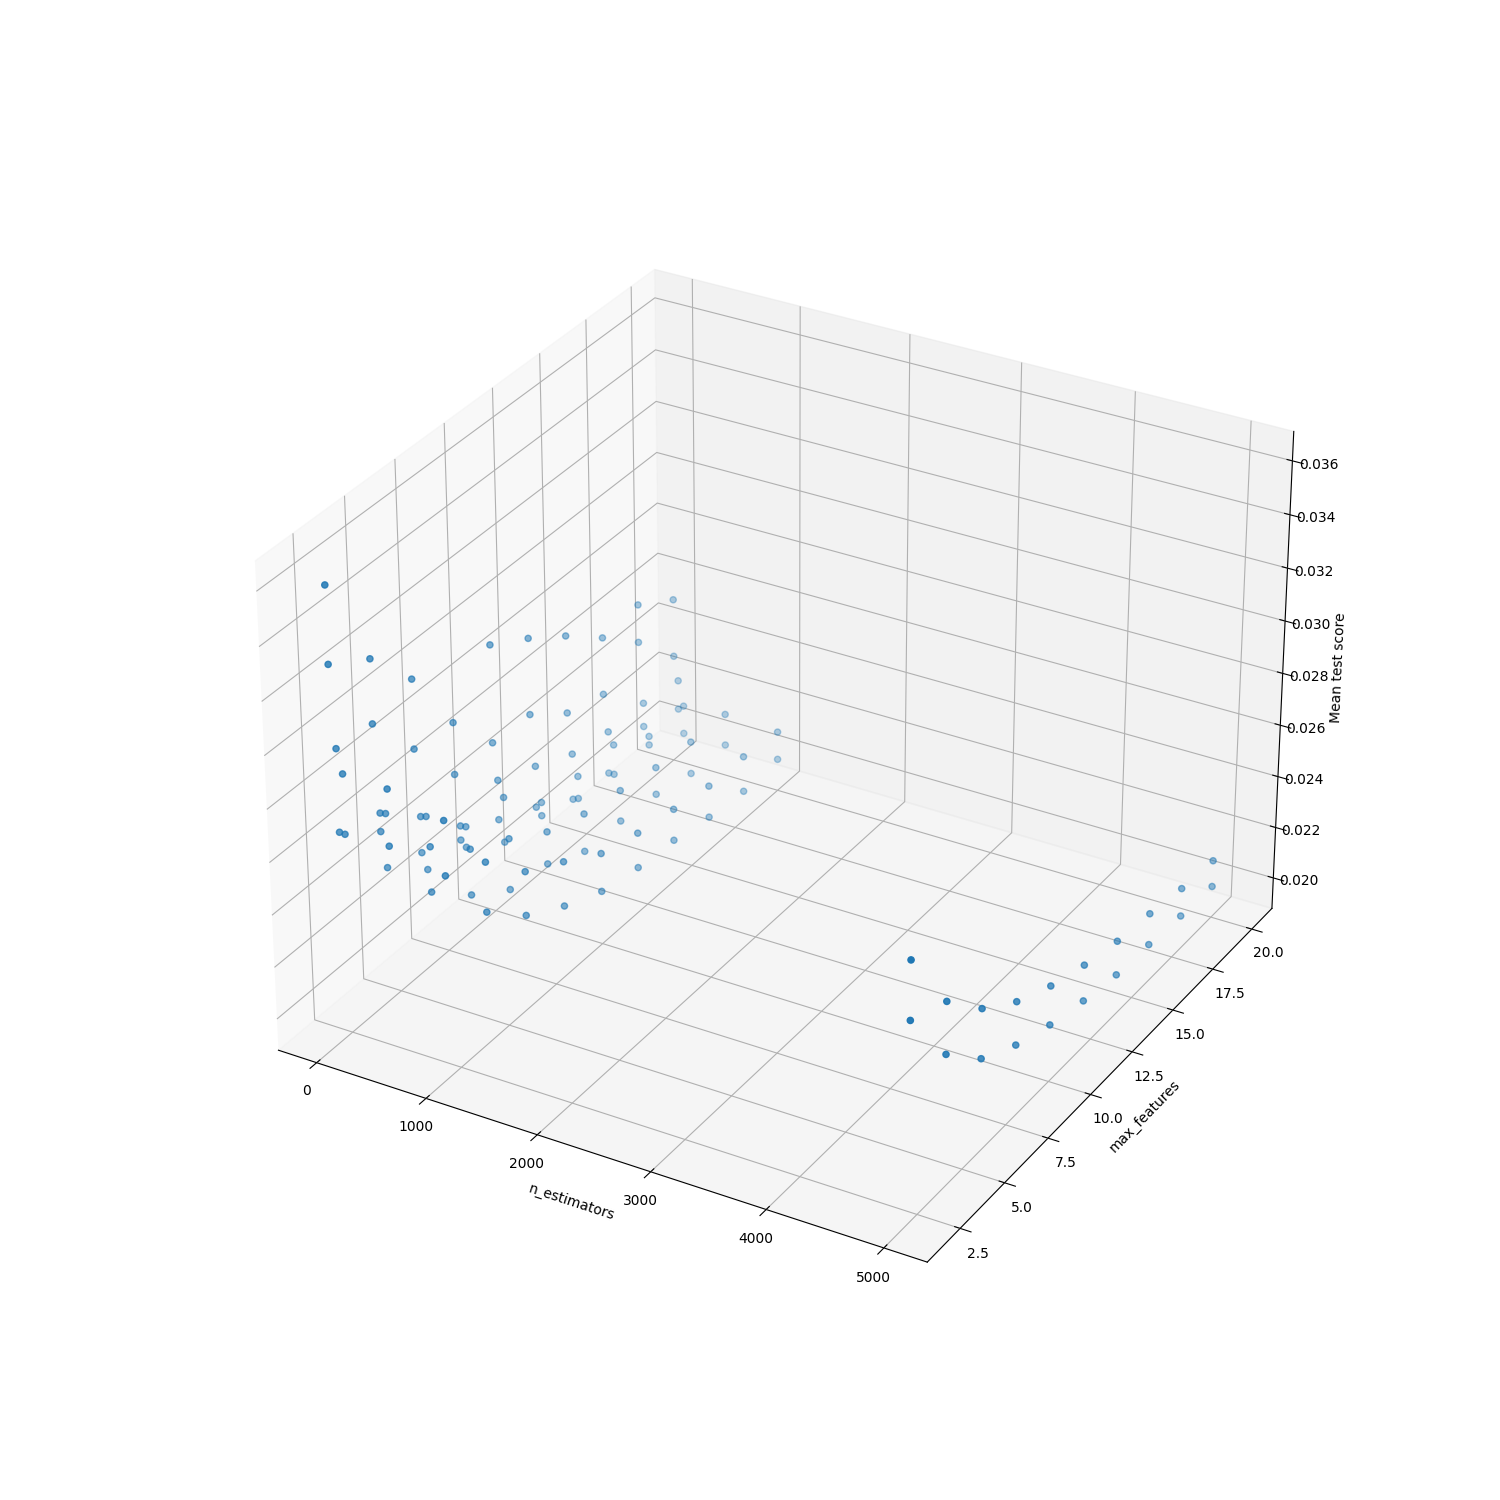

In [95]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection = '3d')

x = df_rforest_gridsearch['n_estimators']
y = df_rforest_gridsearch['max_features']
z = df_rforest_gridsearch['mean_test_score']

ax.set_xlabel("n_estimators")
ax.set_ylabel("max_features")
ax.set_zlabel("Mean test score")

ax.scatter(x, y, z)
plt.show()

In [97]:
rforest_reg = gscv_rforest.best_estimator_
rforest_reg

RandomForestRegressor(bootstrap=False, max_features=18, n_estimators=1000)

In [ ]:
n_estimators = 1000
samples = df_rforest_gridsearch[df_rforest_gridsearch['n_estimators'] == n_estimators]
upper_bound = samples['mean_test_score'] + samples['std_test_score']
lower_bound = samples['mean_test_score'] - samples['std_test_score']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(samples['max_features'], samples['mean_test_score'])
plt.fill_between(samples['max_features'], upper_bound, lower_bound, alpha=0.5)
#ax.set_ybound(lower=0.0, upper=0.05)
#plt.xticks(range(0, 1001, 100));

In [101]:
grid_params = [
    {'bootstrap': [False], 'n_estimators': [x for x in range(200, 2001, 200)], 'max_features': [x for x in range(15, 26)]},
]
gscv_rforest = GridSearchCV(estimator=tree_reg, param_grid=grid_params, cv=5, scoring='neg_mean_squared_log_error', return_train_score=True)

In [102]:
gscv_rforest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False],
                          'max_features': [15, 16, 17, 18, 19, 20, 21, 22, 23,
                                           24, 25],
                          'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400,
                                           1600, 1800, 2000]}],
             return_train_score=True, scoring='neg_mean_squared_log_error')

Determining features' relative importance

In [103]:
gscv_rforest.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=25, n_estimators=1000)

In [104]:
rforest_reg = gscv_rforest.best_estimator_

In [105]:
model = rforest_reg
step = 3
X_t = X_train.to_numpy()
X_v = X_test.to_numpy()
y_t, y_v = y_train, y_test
train_errors, val_errors = [], []
for m in range(1, len(X_t), step):
    model.fit(X_t[:m], y_t[:m])
    y_t_predict = model.predict(X_t[:m])
    y_v_predict = model.predict(X_v)
    train_errors.append(mean_squared_error(y_t[:m], y_t_predict))
    val_errors.append(mean_squared_error(y_v, y_v_predict))

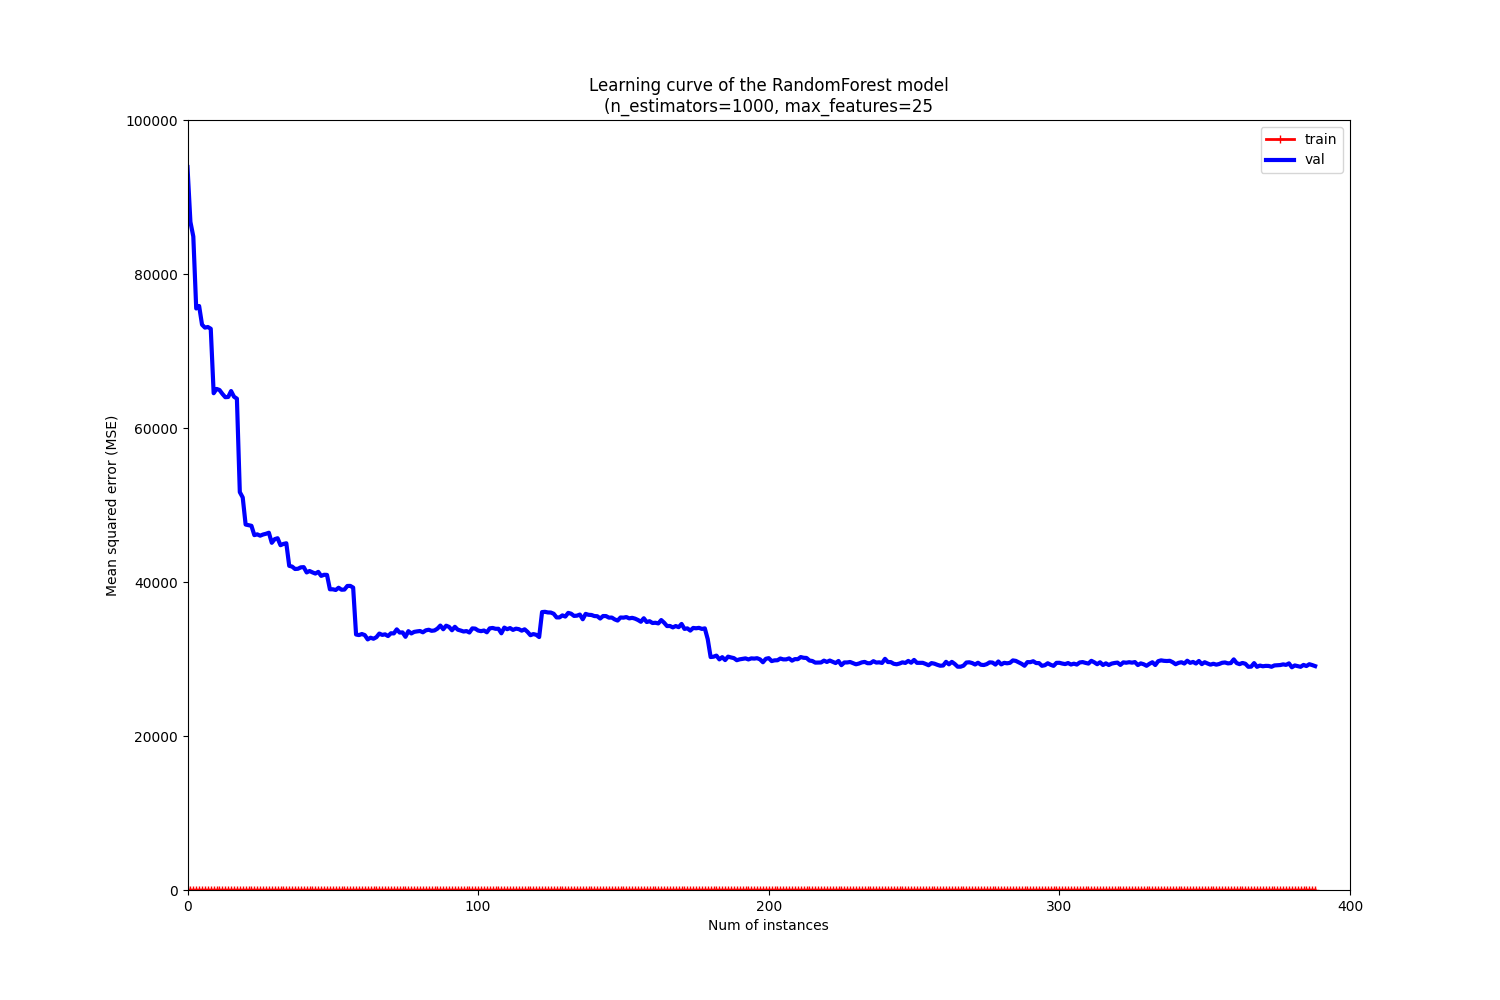

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
plt.legend()
ax.set_title('Learning curve of the RandomForest model\n(n_estimators=1000, max_features=25')
ax.set_ybound(lower=0.0, upper=1e5)
#ax.set_yticks()
ax.set_ylabel('Mean squared error (MSE)')
upper_x_bound = (int(len(train_errors)/100)+1)*100
ax.set_xbound(lower=0, upper=upper_x_bound)
ax.set_xlabel('Num of instances')
ax.set_xticks(range(0, upper_x_bound+1, 100));
#plt.xticks(range(0, upper_x_bound+1, 100));

## Make prediction for Kaggle

In [87]:
# loading processed data from data_clean_prepare.ipynb results
final_X_test = np.genfromtxt('datasets/processed/test_numpy.csv', delimiter=',')
final_X_test.shape

(1459, 242)

In [92]:
df_test = pd.read_csv('datasets/test.csv', index_col=0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearB

In [91]:
predictions = work_model.predict(final_X_test)
df_predictions = pd.Series(predictions, index=df_test.index, name='SalePrice')
df_predictions.info()

In [96]:
df_predictions.to_csv('datasets/test_predictions_v1.csv')